Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Import all the libraries needed

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob # import the glob module
import PIL
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Sequential

## Read assignment data

In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Copy the zip file to Colab's local filesystem
!cp '/content/drive/My Drive/Colab Notebooks/cnn_assignment/CNN_assignment.zip' /content/

# Step 3: Unzip the file in Colab's local storage
import zipfile
with zipfile.ZipFile('/content/CNN_assignment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Step 4: Verify the extraction
import os
print(os.listdir('/content/'))


Mounted at /content/drive
['.config', 'Skin cancer ISIC The International Skin Imaging Collaboration', 'CNN_assignment.zip', 'drive', 'sample_data']


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
path_to_train_directory = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
path_to_test_directory = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Model1:

Let's train the model with images from train and test folders

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [19]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123)

Found 118 files belonging to 9 classes.


In [20]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Training Data


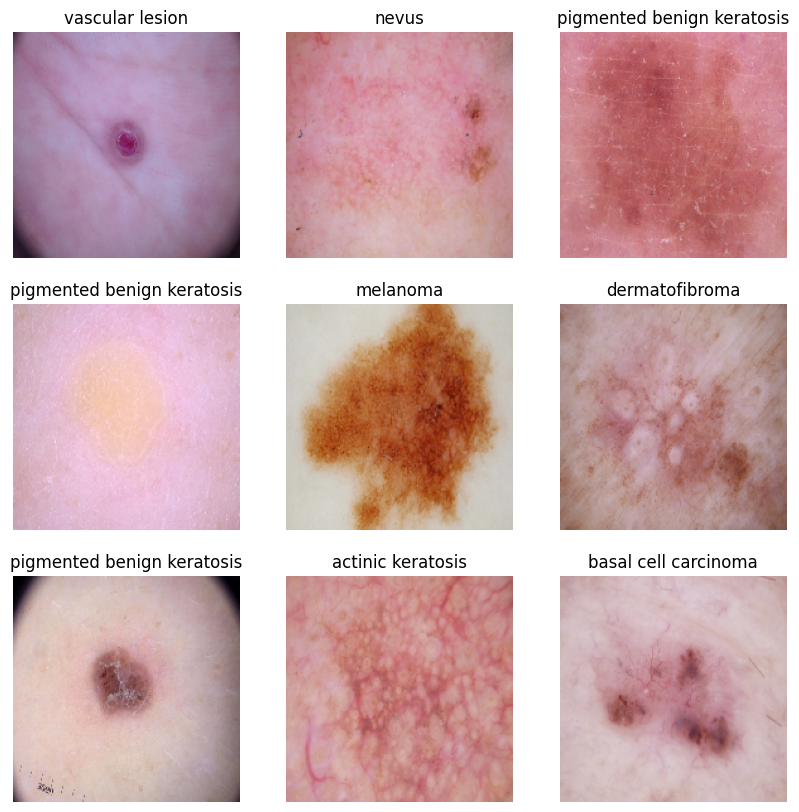

In [9]:
### your code goes here, you can use training or validation data to visualize
print("Training Data")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Validation Data


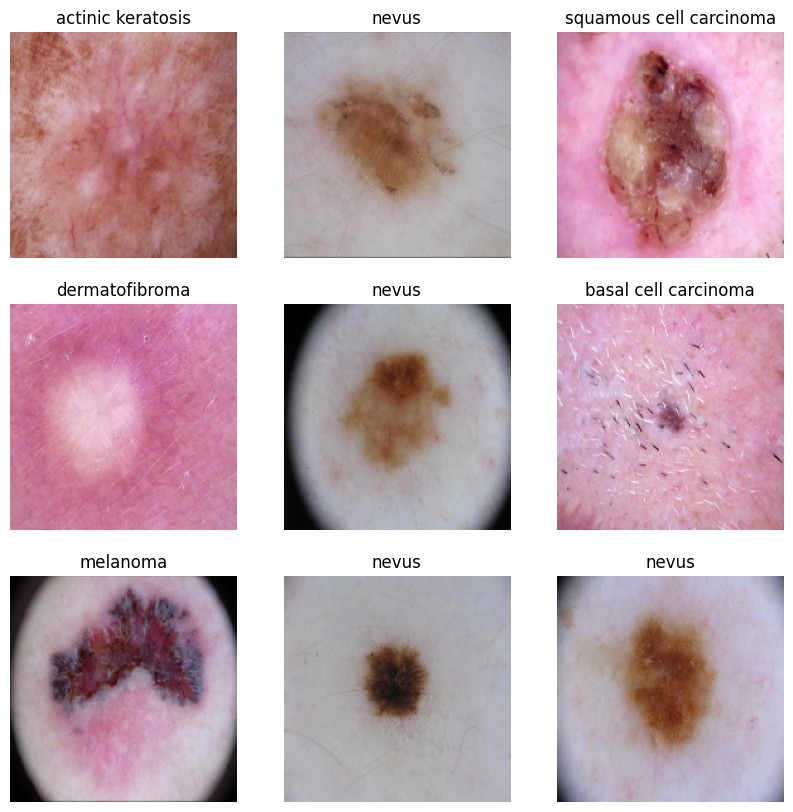

In [10]:
print("Validation Data")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

###Autotune to speedup training

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds1 = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Your code goes here
model = Sequential()

model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 236672)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     121,176,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,441,353 (463.26 MB)

 Trainable params: 121,441,353 (463.26 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds1,
  validation_data=val_ds1,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.1858 - loss: 2.0798 - val_accuracy: 0.1356 - val_loss: 2.1499
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1974 - loss: 2.0569 - val_accuracy: 0.1610 - val_loss: 2.1513
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2209 - loss: 2.0163 - val_accuracy: 0.1695 - val_loss: 2.1452
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2607 - loss: 1.9721 - val_accuracy: 0.2373 - val_loss: 2.0813
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2984 - loss: 1.9246 - val_accuracy: 0.2458 - val_loss: 2.0712
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2967 - loss: 1.8947 - val_accuracy: 0.2797 - val_loss: 2.0203
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3104 - loss: 1.8585 - val_accuracy: 0.2712 - val_loss: 2.0136
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3490 - loss: 1.7986 - val_accuracy: 0.3220 -

### Visualizing training results

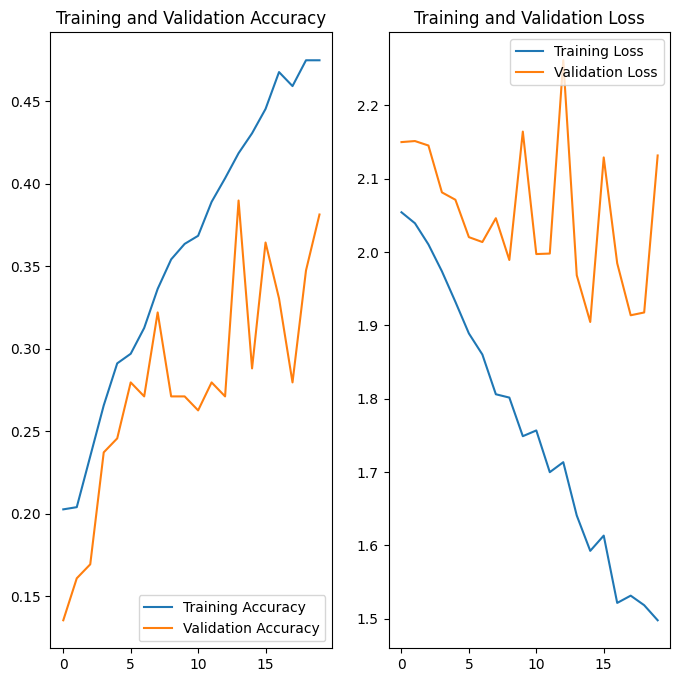

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

### **Analysis of the Model Fit History**

#From the given training history:

# - **Training Loss and Accuracy**:
#   - The **training loss** consistently decreases Epoch 1 to Epoch 20, while the **training accuracy** improves continuously.
#   - This suggests that the model is learning and improving over the training epochs.

# - **Validation Loss and Accuracy**:
#   - The **validation loss** fluctuates, initially decreasing, and later increasing in some epochs but not consistently.
#   - The **validation accuracy** shows some improvement but fluctuates.

# ### **Key Observations**:

# 1. **Underfitting**: The model starts with low training accuracy and high loss, indicating the model needs more epochs to fully learn from the training data.

# 2. **Overfitting**:
#    - **Validation Accuracy vs Training Accuracy**: From the first epoch, the training accuracy continues to improve, while validation accuracy fluctuates.
#                                                    This is a sign of **overfitting**. The model performs well on the training data but struggles to generalize on the validation set.
#    - **Validation Loss**: The validation loss keeps fluctuating a lot and eventually increases towards end while the training loss continues to decrease, another sign of overfitting.

# 3. **Imbalance Between Training and Validation Metrics**: The gap between training and validation performance suggests the model is memorizing the training data rather than
#                                                           generalizing well on unseen data.

# ### **Appropriate Data Augmentation Strategy**:

# To combat **overfitting**, you can apply **data augmentation** to artificially increase the diversity of the training data, helping the model generalize better.

# #### **Common Data Augmentation Techniques**:
# 1. **Random Flip**: Horizontally flip the image randomly. This helps when the object’s orientation is not critical.
# 2. **Random Rotation**: Apply random rotations to the images to make the model more robust to orientation changes.
# 3. **Random Zoom**: Randomly zoom in/out on images to vary the scale of the objects in the image.
# 4. **Random Contrast/Brightness**: Slightly alter the contrast or brightness to simulate different lighting conditions.
# 5. **Random Translation**: Shift the image horizontally or vertically by a random amount.
# 6. **Image Normalization**: Normalize pixel values to make the model less sensitive to different image intensities.
# 7. **Regularization**: Apply L2 regularization to the layers to penalize large weights and avoid overfitting.

### **Conclusion**:
#The model is **overfitting** after around 15 epochs. To mitigate this, you should introduce **data augmentation**, add regularization techniques like **dropout** and **L2 regularization**,
#and use **early stopping** to prevent overfitting. Data augmentation will improve the generalization of your model by providing diverse training data.

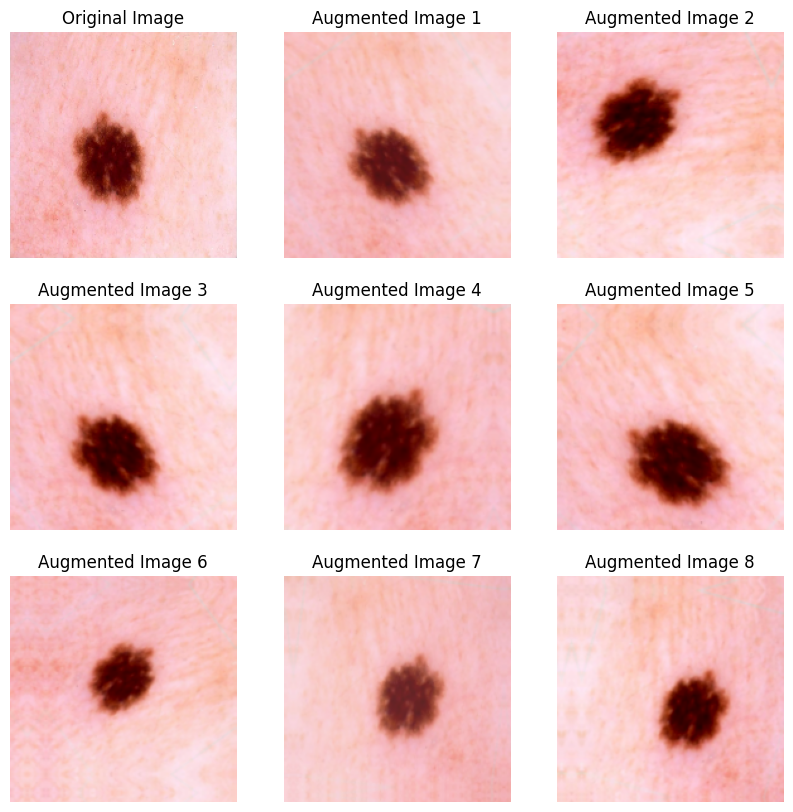

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
sample_image = None
# Load a sample image from your dataset
for images, labels in train_ds.take(1):
    sample_image = images[0].numpy().astype("uint8")
    break

# Create the data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

# Plot the original image and several augmented versions of it
plt.figure(figsize=(10, 10))

# Display the original image
ax = plt.subplot(3, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

# Apply augmentation and display augmented images
for i in range(8):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title("Augmented Image " + str(i+1))
    plt.axis("off")

plt.show()

## Model2:

Lets add augmentation and see if it makes any difference to accuracy


In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Create training dataset

In [6]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Create validation dataset

In [7]:
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Autotune to speedup training

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [9]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

# Adding data augmentation to your model
model2 = Sequential([
    data_augmentation  # Augmentation is only applied during training
])

#model2 = Sequential()

model2.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model2.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height, img_width, 3), kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(9, kernel_regularizer=regularizers.l2(0.001)))
model2.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [10]:
## Your code goes here
model2.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# View the summary of all layers
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [12]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.2062 - loss: 3.3970 - val_accuracy: 0.2058 - val_loss: 3.3830
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2089 - loss: 3.3430 - val_accuracy: 0.2058 - val_loss: 3.3573
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2348 - loss: 3.3298 - val_accuracy: 0.2081 - val_loss: 3.3216
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2503 - loss: 3.3106 - val_accuracy: 0.2975 - val_loss: 3.2865
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2622 - loss: 3.2740 - val_accuracy: 0.2573 - val_loss: 3.3301
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2740 - loss: 3.2631 - val_accuracy: 0.2685 - val_loss: 3.2088
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2898 - loss: 3.2459 - val_accuracy: 0.3736 - val_loss: 3.1275
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3081 - loss: 3.2147 - val_accuracy: 0.2886 - 

### Visualizing the results

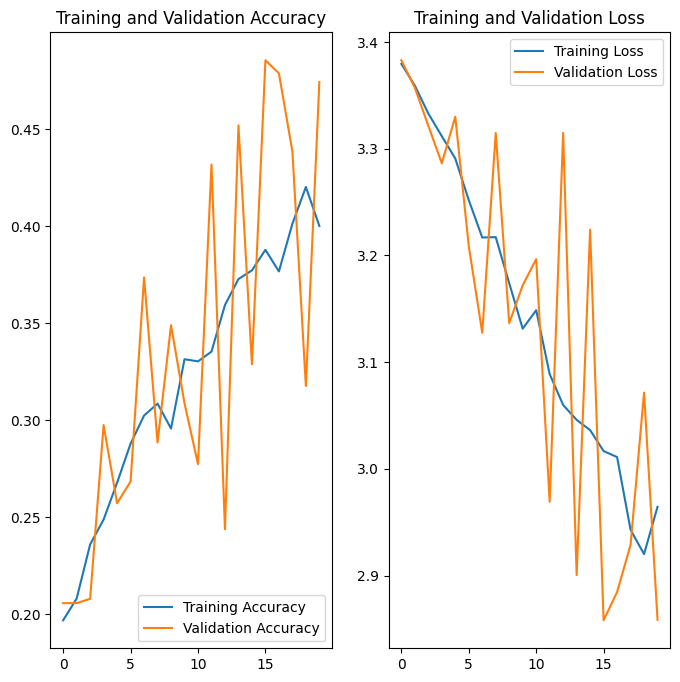

In [13]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [14]:
## Your code goes here.
import collections

# Initialize a dictionary to store class counts
class_counts = collections.Counter()

# Iterate through the training dataset and count each class
for images, labels in train_ds2:
  class_counts.update(labels.numpy())

# Convert the counts into a list ordered by class index (for consistency)
counts_per_class = [class_counts[i] for i in range(len(class_names))]

# Plotting the distribution with class names on the x-axis
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts_per_class) # class_names from code cell 8
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)  # Rotate class names if they are long
plt.show()

NameError: name 'class_names' is not defined

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


## Model 3:

**Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

#### **Todo:** Plot the distribution of classes in the training dataset before augmenting.

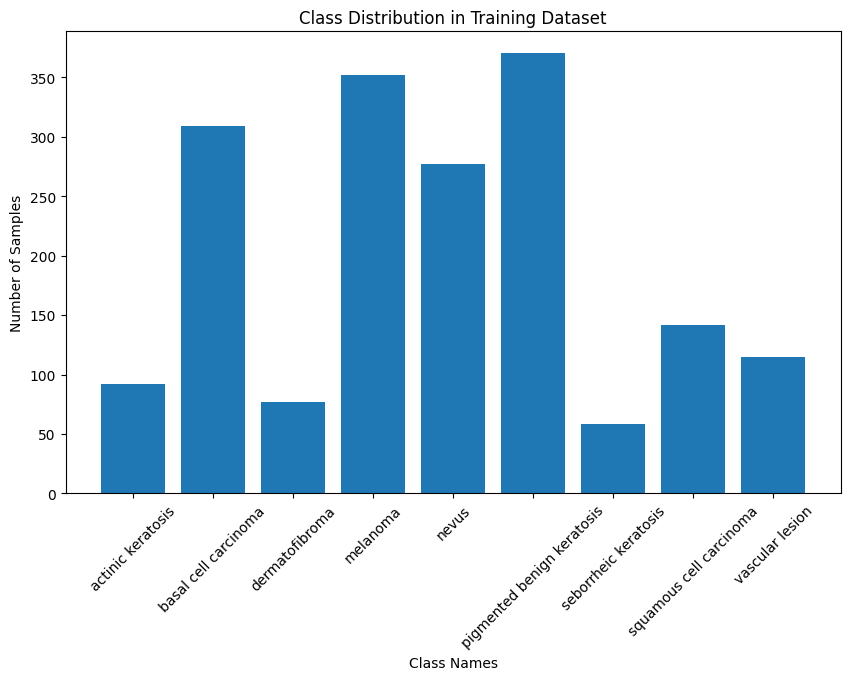

In [21]:
## Your code goes here.
import collections

# Initialize a dictionary to store class counts
class_counts = collections.Counter()

# Iterate through the training dataset and count each class
for images, labels in train_ds2:
  class_counts.update(labels.numpy())

class_names = train_ds.class_names
# Convert the counts into a list ordered by class index (for consistency)
counts_per_class = [class_counts[i] for i in range(len(class_names))]

# Plotting the distribution with class names on the x-axis
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts_per_class) # class_names from code cell 8
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)  # Rotate class names if they are long
plt.show()

### Rectify class imbalance using Augmentor library

In [16]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_train_directory +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4D001867A0>: 100%|██████████| 500/500 [00:02<00:00, 192.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4D001D5930>: 100%|██████████| 500/500 [00:02<00:00, 192.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4D002846A0>: 100%|██████████| 500/500 [00:02<00:00, 185.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E4D0016BD00>: 100%|██████████| 500/500 [00:12<00:00, 39.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2155x1958 at 0x7E4D281AB1C0>: 100%|██████████| 500/500 [00:13<00:00, 36.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4D0074C1F0>: 100%|██████████| 500/500 [00:02<00:00, 179.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E4D281B6050>: 100%|██████████| 500/500 [00:05<00:00, 88.44 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E4D2BFB68F0>: 100%|██████████| 500/500 [00:02<00:00, 193.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E4D002D9630>: 100%|██████████| 500/500 [00:02<00:00, 195.20 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
# create dataframe out of train_ds with image path and label as 2 columns
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

# populate lesion_list with class name
lesion_list = []
for path in path_list:
    lesion_list.append(path.split('/')[-2])

dataframe_dict = dict(zip(path_list, lesion_list))

original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path', 'Label'])

In [25]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [26]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [27]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [28]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [29]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Plot the distribution of classes in the training dataset.

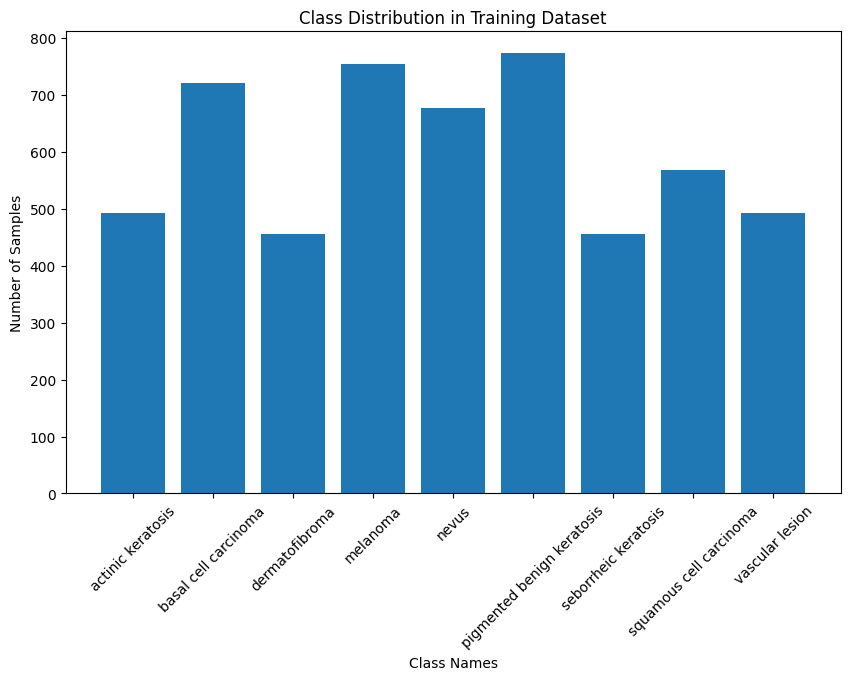

In [30]:
## Your code goes here.
import collections

# Initialize a dictionary to store class counts
class_counts = collections.Counter()

# Iterate through the training dataset and count each class
for images, labels in train_ds3:
  class_counts.update(labels.numpy())

# Convert the counts into a list ordered by class index (for consistency)
counts_per_class = [class_counts[i] for i in range(len(class_names))]

# Plotting the distribution with class names on the x-axis
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts_per_class) # class_names from code cell 8
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)  # Rotate class names if they are long
plt.show()

### Create a validation dataset

In [31]:
val_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [32]:
### Your code goes here
model3 = Sequential()

# data_augmentation = Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomTranslation(0.1, 0.1),
#     layers.RandomContrast(0.2)
# ])

# # Adding data augmentation to your model
# model3 = Sequential([
#     data_augmentation  # Augmentation is only applied during training
# ])

model3.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model3.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_height, img_width, 3), kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(9, kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile your model (Choose optimizer and loss function appropriately)

In [33]:
### Todo, choose an appropirate optimiser and loss function
model3.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 180, 180, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 178, 178, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 89, 89, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 89, 89, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 87, 87, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 236672)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │     121,176,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,441,353 (463.26 MB)

 Trainable params: 121,441,353 (463.26 MB)

 Non-trainable params: 0 (0.00 B)

### Train your model

In [35]:
epochs = 30
## Your code goes here, use 50 epochs.
history3 = model3.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.1560 - loss: 3.4996 - val_accuracy: 0.2428 - val_loss: 3.4179
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2052 - loss: 3.4130 - val_accuracy: 0.2502 - val_loss: 3.2680
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2344 - loss: 3.3198 - val_accuracy: 0.1960 - val_loss: 3.4368
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2609 - loss: 3.2446 - val_accuracy: 0.3066 - val_loss: 3.0789
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3004 - loss: 3.1496 - val_accuracy: 0.3526 - val_loss: 3.0558
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3438 - loss: 3.0324 - val_accuracy: 0.3860 - val_loss: 2.9782
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3805 - loss: 2.9365 - val_accuracy: 0.3868 - val_loss: 2.8787
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4014 - loss: 2.8969 - val_acc

###  Visualize the model results

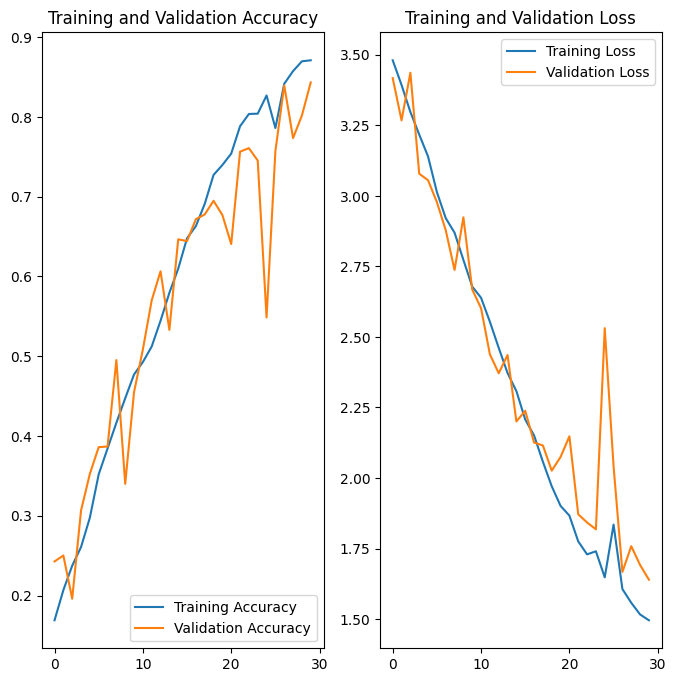

In [37]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
# **Underfitting**:
# Initially, there were signs of underfitting (low accuracy, high loss) during the first few epochs. However, this problem seems to be resolved by the middle epochs (around epoch 5-10),
# as both training and validation metrics improve significantly.

# **Overfitting**:
# By the later epochs (15-30), the model's training accuracy and the validation accuracy stabilizes around 75-89%.
# This indicates the model is fitting very well to the training data, but the slight gap between training and validation metrics shows a potential overfitting trend.
# Validation loss stabilizes after epoch 26, but the lower training loss and higher validation loss indicate the model may be overfitting slightly toward the end.

# **Class Rebalance Helped**
# Class rebalance helped in improving the model’s performance:
# After using the Augmentor library, validation accuracy improved significantly from the early epochs (~25%) to later stages (~80%).
# This suggests the model is now handling the class distribution better, and the previously underrepresented classes are being recognized more accurately.
# Continuous drop in validation loss after suggests the rebalance enabled the model to generalize better across all classes.
# Training loss and and validation loss consistently decreases, indicating that the model can now correctly classify instances from different classes more effectively.

## Use Model 3 to predict and visualize model results on Test dataset

#### Visually verify prediction results from the model

In [38]:
unseen_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed=123)
class_names = unseen_ds.class_names

predictions = model3.predict(unseen_ds)
predicted_classes = np.argmax(predictions, axis=1)
# Get predicted class names
predicted_class_names = [class_names[i] for i in predicted_classes]

unseen_image_paths = tf.data.Dataset.list_files('Skin cancer ISIC The International Skin Imaging Collaboration/Test/*/*')
image_paths_list = list(unseen_image_paths.as_numpy_iterator())  # Convert paths to a list

# Pair the image paths with predictions
for img_path, pred_class in zip(image_paths_list, predicted_class_names):
    print(f"Image: {img_path} -> Predicted Class: {pred_class}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000031.jpg' -> Predicted Class: nevus
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024375.jpg' -> Predicted Class: nevus
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/ISIC_0024432.jpg' -> Predicted Class: pigmented benign keratosis
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000030.jpg' -> Predicted Class: actinic keratosis
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000035.jpg' -> Predicted Class: nevus
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000013.jpg' -> Predicted Class: basal cell carcinoma
Image: b'Skin cancer ISIC The International Skin Imaging Collaboration/Test/vasc

In [39]:
loss, accuracy = model3.evaluate(unseen_ds)
print(f'Unseen data accuracy: {accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.3726 - loss: 4.1799
Unseen data accuracy: 38.98%
